In [10]:
from pathlib import Path
from util.coord_transforms import freqSpaceCoords

import os
import numpy as np
import matplotlib.pyplot as plt
from flow_analysis_comps.Fourier.OrientationSpaceManager import orientationSpaceManager
import dask.array as da
from dask import delayed
import tifffile
import flow_analysis_comps.Fourier.OrientationSpaceFilter as OSFilter
import colorcet

%matplotlib widget


In [11]:
data_adr = Path(r"G:\AMOLF_Data\AMOLF-SHIMIZU Dropbox\Simon van Staalduine")
plate_id = r"20250122_Plate017"
video_id = r"033"
frame_id1 = r"Img/Img_00000.tif"
frame_id2 = r"Img/Img_00001.tif"
# total_path = Path(r"U:\test_data\015\Img")
total_path = data_adr / video_id / "Img"


print(total_path)

G:\AMOLF_Data\AMOLF-SHIMIZU Dropbox\Simon van Staalduine\033\Img


In [12]:

def load_tif_series_to_dask(folder_path):
    """
    Loads a series of .tif images from a folder into a Dask array.

    Parameters:
        folder_path (str): Path to the folder containing the .tif images.

    Returns:
        dask.array.Array: A Dask array representing the .tif series.
    """
    # Get sorted list of .tif files
    tif_files = sorted(
        [
            os.path.join(folder_path, f)
            for f in os.listdir(folder_path)
            if f.lower().endswith(".tif")
        ],
        # key=lambda x: int(os.path.basename(x)[3:].split('.')[0])  # Extract number from 'Img<nr>.tif'
    )

    if not tif_files:
        raise ValueError("No .tif files found in the specified folder.")

    # Use Dask to stack images lazily
    sample_image = tifffile.imread(tif_files[0])
    dtype = sample_image.dtype
    shape = (len(tif_files),) + sample_image.shape

    def lazy_reader(filename):
        return tifffile.imread(filename)

    dask_array = da.stack(
        [
            da.from_delayed(
                delayed(lazy_reader)(file), shape=sample_image.shape, dtype=dtype
            )
            for file in tif_files
        ]
    )

    return dask_array


array = load_tif_series_to_dask(total_path) # Dims are z, y, x

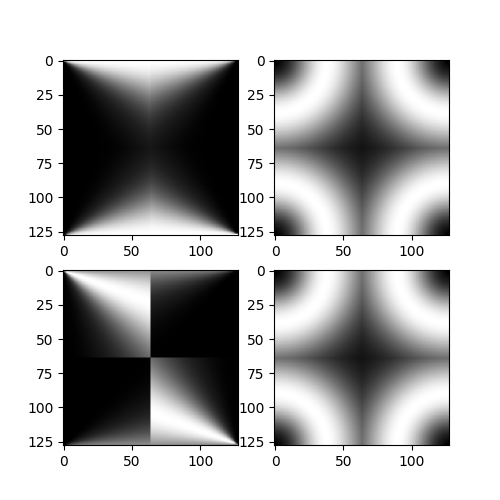

In [13]:
N = 128
coord_system = freqSpaceCoords(np.array([N, N]))
# print(coord_system.rho)

ret_val = OSFilter.angular_kernel(K=4, coord_system=coord_system).real
ret_val_rad = OSFilter.radial_kernel(0.3, coord_system=coord_system)
nr_of_filters = 2
# print(ret_val.shape)

fig, ax = plt.subplots(nr_of_filters, 2, figsize=(5, 5))
for i in range(nr_of_filters):
    ax[i, 0].imshow(ret_val[:, :, i], cmap="cet_CET_L1", vmin=0)
    ax[i, 1].imshow(ret_val_rad[:, :], cmap="cet_CET_L1", vmin=0)


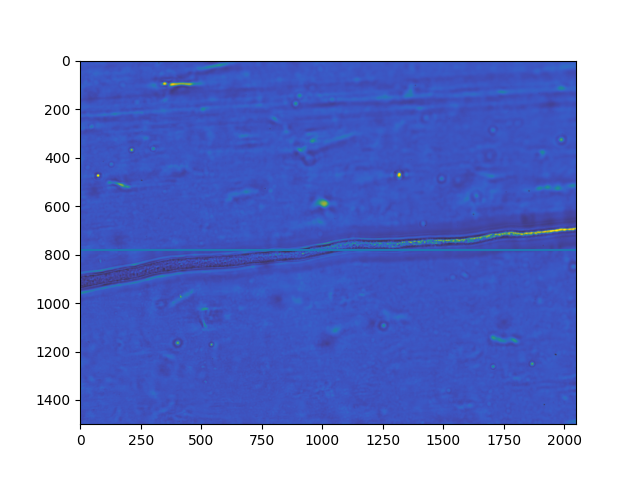

In [14]:

from matplotlib import pyplot as plt

line_height = 780

fig, ax = plt.subplots()
ax.imshow(array[0, :, :], cmap="cet_CET_L20")
ax.axhline(line_height)

# Cutting out an image with (z,x) axes
img = array[:, line_height, 1000:1500]


Initiating filters on new image with dims (600, 500)


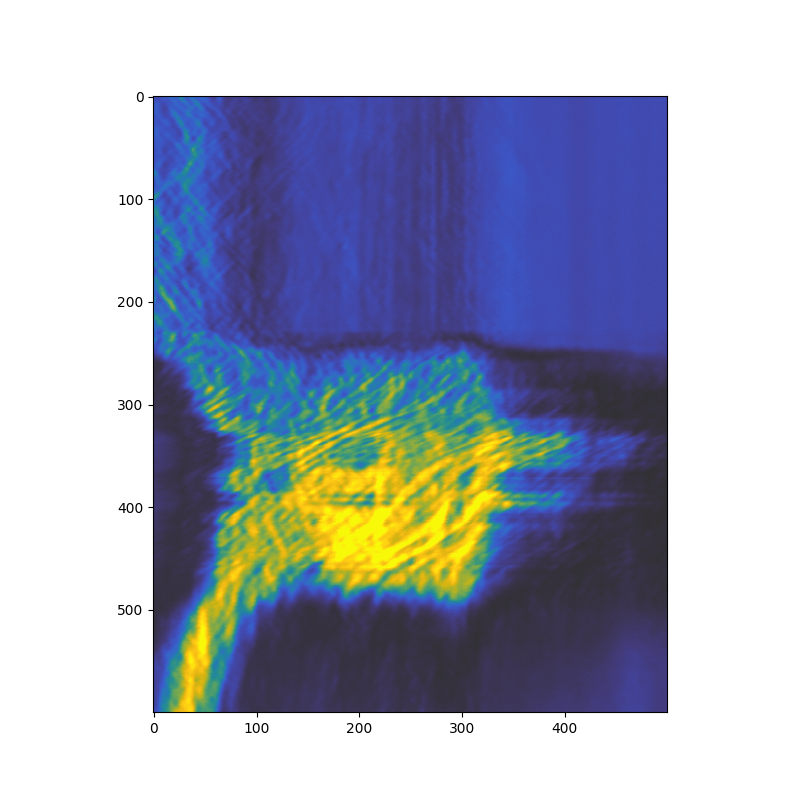

In [15]:
fix, ax = plt.subplots(figsize=(8, 8))
ax.imshow(img, cmap="cet_CET_L20")
ax.set_aspect('equal')

OSFilter = orientationSpaceManager(0.25, K=8)
img_fft = OSFilter.get_response(img)


[0.         0.18479957 0.36959914 0.5543987  0.73919827 0.92399784
 1.10879741 1.29359698 1.47839654 1.66319611 1.84799568 2.03279525
 2.21759481 2.40239438 2.58719395 2.77199352 2.95679309]


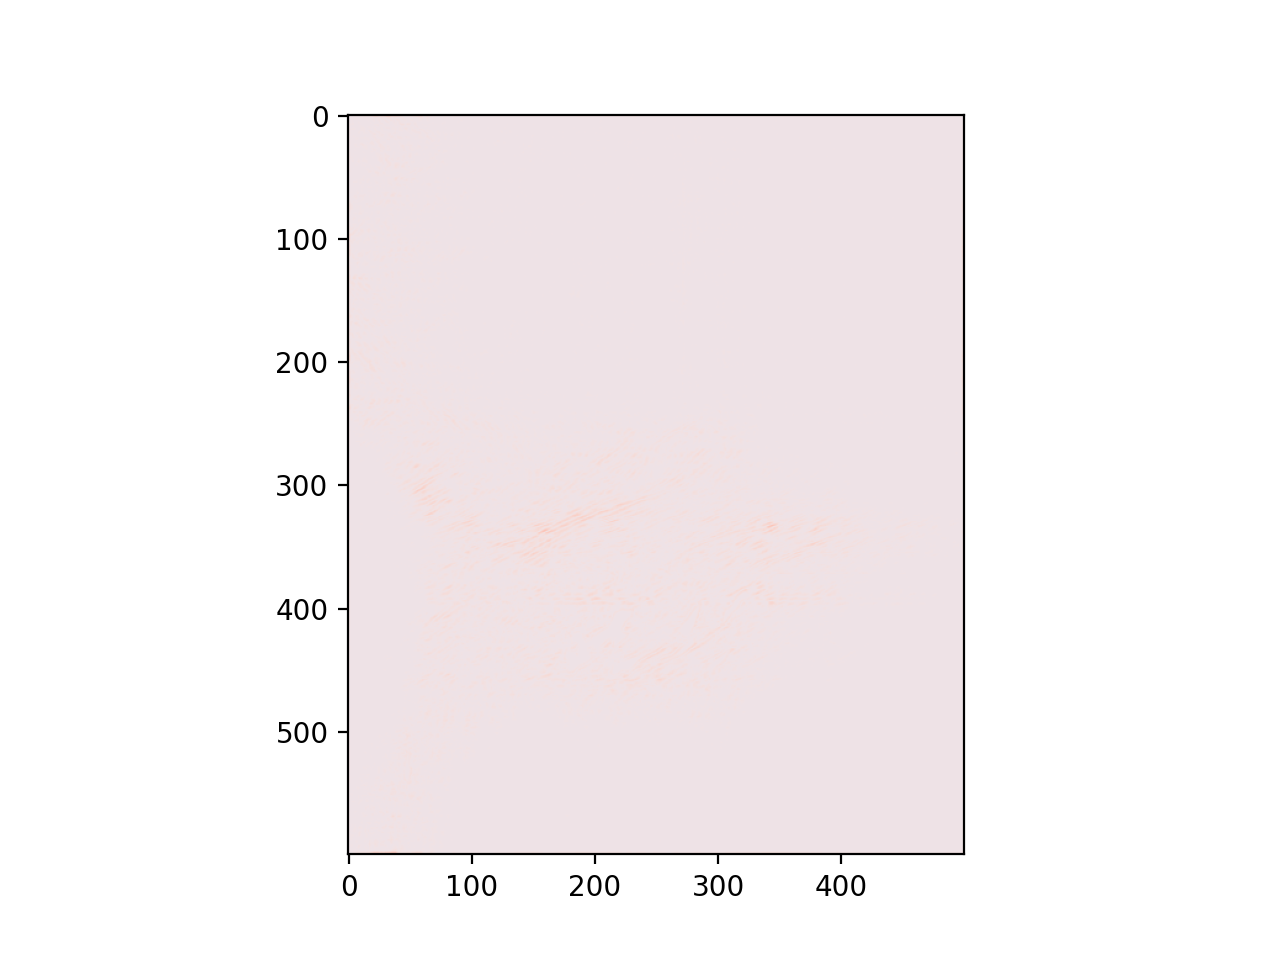

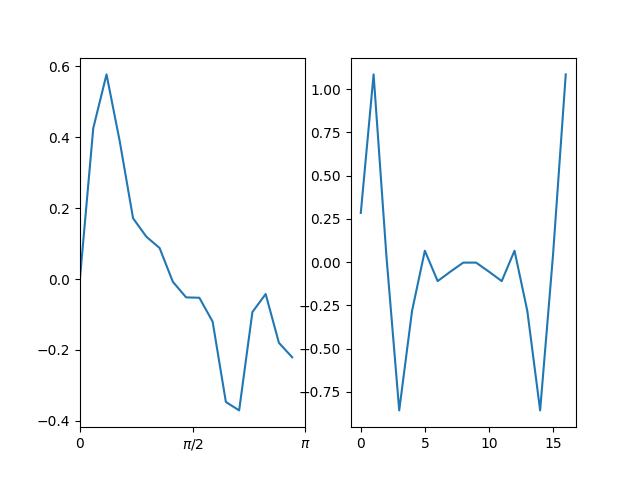

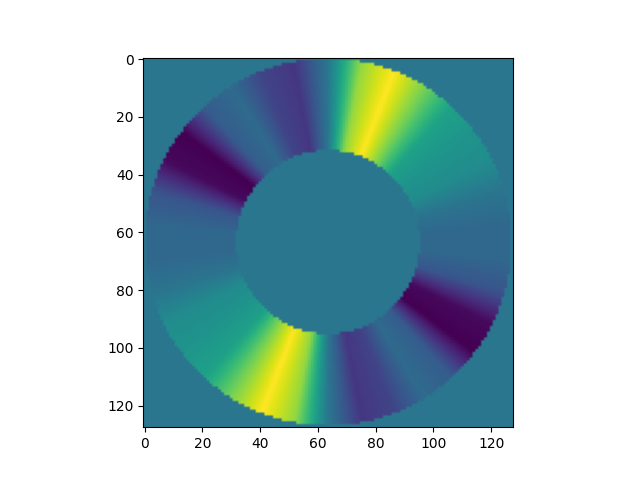

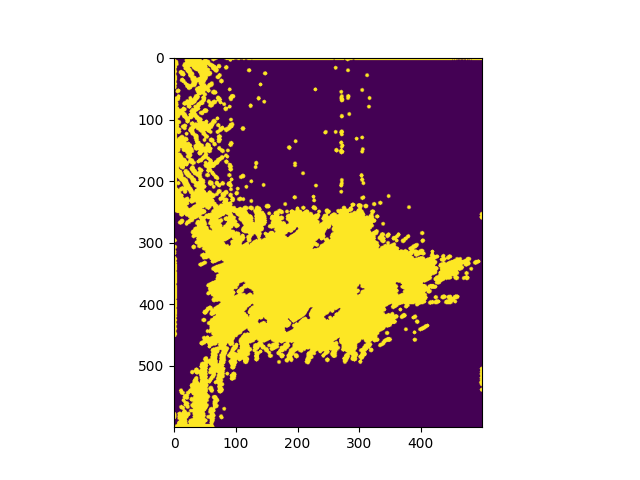

In [16]:
point = (384, 80)

fig = OSFilter.response.plot_mean_response()
thres = OSFilter.response.nlms_mask(fill_holes=True)
OSFilter.response.plot_lineof_point(point)
OSFilter.response.visualize_point_response(point)

fig, ax = plt.subplots()
ax.imshow(thres)

In [17]:
res = OSFilter.orientation_process_1()

# OSFilter.response.plot_mean_response()


(600, 500)
(600, 500)
(600, 500, 3)
(600, 500, 3)
(602, 502, 53)


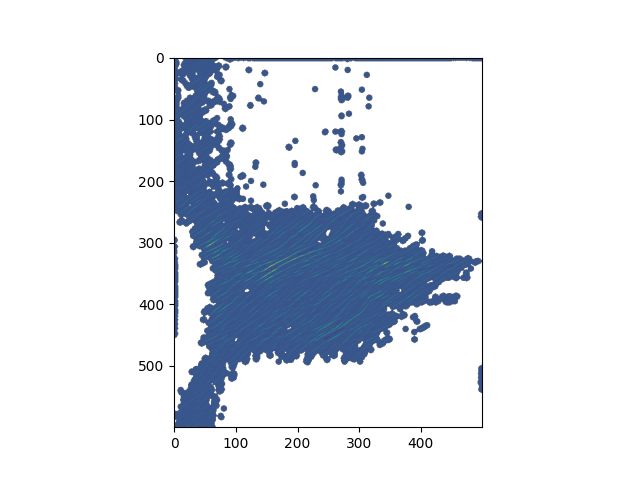

In [18]:
fig, ax = plt.subplots()
ax.imshow(res)